#**Preparation Work**

In [ ]:
# Whether to configure GPU
!nvidia-smi

# Connect to cloud disk
from google.colab import drive
drive.mount('/content/drive')

# Path
KAGGLE_USERNAME = "shuaili1027"
KAGGLE_KEY = "beee2ad2dc4643ae8cbe1a8e9d7a8014"
REPRODUCIBILITY_PATH = '/content/drive/MyDrive/HAM10000/data/*'
SAVE_PATH = '/content/drive/MyDrive/HAM10000/ResNet34/PGD-CATS'

# Load data HAM10000
!mkdir /root/.kaggle
import json
token = {"username":f"{KAGGLE_USERNAME}","key":f"{KAGGLE_KEY}"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir /content/data
!kaggle datasets download kmader/skin-cancer-mnist-ham10000 -p /content/data
!unzip -o /content/data/skin-cancer-mnist-ham10000.zip -d /content/data
!rm -rf /content/data/HAM10000_images_part_1
!rm -rf /content/data/HAM10000_images_part_2
%cd /content/data/ham10000_images_part_1/
!ls -1 | wc -l
%cd /content/data/ham10000_images_part_2/
!ls -1 | wc -l
!gsutil -m cp -R $REPRODUCIBILITY_PATH /content/data/
!pip install robustness==1.1..post2

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/ham10000_images_part_2/ISIC_0029417.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029418.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029419.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029420.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029421.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029422.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029423.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029424.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029425.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029426.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029427.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029428.jpg  
  inflating: /content/data/ham10000_images_part_2/ISIC_0029429.jpg  
  inflating: /content/data/ham10000_images_part_2/IS

#**Import Package**

In [ ]:
# When torch>0.4.0 is changed according to the version of torch----->from torch.hub import load_state_dict_from_url
import os
import time
import random, math
import numpy as np
import pandas as pd
import torch as ch
import seaborn as sns
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
from torch.optim import Adam ,lr_scheduler
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
from torch import nn
from robustness import imagenet_models
from robustness import attack_steps
from robustness.tools import helpers
from torch.utils.data import Dataset,DataLoader
from collections import OrderedDict
from torch.serialization import load
import torchvision.datasets as datasets
from sklearn import datasets
from sklearn.manifold import TSNE
from pandas.core.frame import DataFrame
from scipy import interp
from itertools import cycle
from scipy.sparse.linalg.dsolve.linsolve import use_solver
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score

#**Data preprocessing**

In [ ]:
#randomness
def fix_random_seed(seed):
  ch.backends.cudnn.deterministic = True
  ch.backends.cudnn.benchmark = False
  ch.manual_seed(seed)
  ch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
def upsample_dataframe(df):
  df_upsampled = df.iloc[0:0]
  counts = df['dx'].value_counts().to_dict()
  maxx = np.max(list(counts.values()))
  for lesion, count in counts.items():
    upsampling_factor = int(np.ceil(maxx / count))
    aux = df.iloc[0:0]
    for i in range(upsampling_factor):
      aux = aux.append(df.loc[df['dx'] == lesion])
    aux.reset_index(inplace=True, drop=True)
    aux.drop(np.arange(maxx, aux.shape[0]), inplace=True)
    df_upsampled = df_upsampled.append(aux)
  df_upsampled.reset_index(inplace=True, drop=True)
  return df_upsampled

In [ ]:
class HAM10000_dataset_3cls_balanced(Dataset):
  def __init__(self, root, file_name, train=True, download=None, transform=None, upsample=True, test=False):
    self.transform = transform
    self.file_name = file_name
    aux = file_name.split('::')
    data_ = pd.read_csv(os.path.join(root, aux[0]))

    if test == True:
      self.df = data_
    else:
      aux = aux[1]
      if aux == '0':
        if train == True:
          self.df = data_[data_['fold'].isin(['1', '2', '3', '4', '5'])]
        else:
          self.df = data_[data_['fold'].isin({'validation'})]
      else:
        train_folds = {'1', '2', '3', '4', '5'}
        train_folds.remove(aux)
        if train == True:
          self.df = data_[data_['fold'].isin(train_folds)]
        else:
          self.df = data_[data_['fold'].isin([aux])]
    if upsample:
      self.df = upsample_dataframe(self.df)
    print(f"Created dataset of length: {len(self.df)}")
    self.df = self.df.reset_index()
    self.df['path'] = root + '/' + self.df.loc[:, 'path_relative']
  def __len__(self):
    return len(self.df)
  def __getitem__(self, index):
    X, y = self._getitem_index(index)
    y = torch.tensor(y)
    if self.transform:
      X = self.transform(X)
    return X, y
  def _getitem_index(self, index):
    X = Image.open(self.df['path'][index])
    y = int(self.df['type'][index])
    return X, y
  def _getitem_image_id(self, image_id):
    row = self.df[self.df.image_id == image_id]
    X = Image.open(row['path'].iloc[0])
    y = int(row['type'].iloc[0])
    return X, y

In [ ]:
input_size = 224
train_transforms, test_transforms= [], []
train_transforms.extend([transforms.CenterCrop(450), transforms.Resize((input_size, input_size))])
test_transforms.extend([transforms.CenterCrop(450),transforms.Resize((input_size, input_size))])
train_transforms.extend([transforms.ColorJitter(0.2, 0.2, 0.2, 0),transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),transforms.RandomAffine(10),
    transforms.RandomRotation(50),transforms.ToTensor()])
test_transforms.extend([transforms.ToTensor()])
TRAIN_TRANSFORMS_HAM10000 = transforms.Compose(train_transforms)
TEST_TRANSFORMS_HAM10000 = transforms.Compose(test_transforms)
VAL_TRANSFORMS_HAM10000 = TEST_TRANSFORMS_HAM10000

In [ ]:
def CreatDataLoader(root=None,file_name=None,train=None,test=None,val=None,transform=None,batch_size=None,workers=None,shuffle=True):
  if train:
    train_set = HAM10000_dataset_3cls_balanced(root=root, file_name=file_name, train=True, download=None, transform=transform, upsample=True, test=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle, num_workers=workers, pin_memory=True)
    return train_loader
  if val:
    val_set = HAM10000_dataset_3cls_balanced(root=root, file_name=file_name, train=False, download=None, transform=transform, upsample=True, test=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=shuffle, num_workers=workers, pin_memory=True)
    return val_loader
  if test:
    test_set = HAM10000_dataset_3cls_balanced(root=root, file_name=file_name, train=False, download=None, transform=transform, upsample=True, test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=shuffle, num_workers=workers, pin_memory=True)
    return test_loader

#**Experimental tool**

In [ ]:
#Data restore image
def inverse_normalize(batch_image, batch_label = None):
  batch_image=batch_image.detach().cpu()
  fig = plt.figure(figsize=(batch_image.size(0) * 2.5, 5))
  for i in range(batch_image.size(0)):
    img = batch_image[i].numpy().transpose(1, 2, 0)
    img = img * 255
    ax = fig.add_subplot(1, batch_image.size(0), i+1, xticks=[], yticks=[])
    plt.imshow(img.astype('uint8'))
    if batch_label is not None:
      ax.set_title(batch_label[i].item())
  plt.show()

In [ ]:
#Early stop mechanism
class EarlyStopping():
  def __init__(self, save_path, patience=10, verbose=False, delta=0 ,type=None):
    self.save_path = save_path
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.type = type
  def __call__(self, val_loss, model):
    if self.best_score is None:
      self.best_score = val_loss
      self.save_checkpoint(val_loss, model)
    elif self.best_score - val_loss > self.delta:
      self.best_score = val_loss
      self.save_checkpoint(val_loss, model)
      self.counter = 0
    elif self.best_score - val_loss < self.delta:
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True
  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    path = os.path.join(self.save_path, f'{self.type}_best_network.pth')
    ch.save(model.state_dict(),path)
    self.val_loss_min = val_loss

In [ ]:
class R_EarlyStopping():
  def __init__(self, save_path, patience=10, verbose=False, delta=0 ,type=None):
    self.save_path = save_path
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.r_acc_max = 0
    self.delta = delta
    self.type = type
  def __call__(self, r_acc, model):
    if self.best_score is None:
      self.best_score = r_acc
      self.save_checkpoint(r_acc, model)
    elif self.best_score - r_acc < self.delta:
      self.best_score = r_acc
      self.save_checkpoint(r_acc, model)
      self.counter = 0
    elif self.best_score - r_acc > self.delta:
      self.counter += 1
      print(f'R_EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        print('INFO: R_Early stopping')
        self.early_stop = True
  def save_checkpoint(self, r_acc, model):
    if self.verbose:
      print(f'Validation loss decreased ({self.r_acc_max:.6f} --> {r_acc:.6f}).  Saving model ...')
    path = os.path.join(self.save_path, f'{self.type}_robust_best_network.pth')
    ch.save(model.state_dict(),path)
    self.r_acc_max = r_acc

In [ ]:
#Create model(ResNet18\34\50)
class Model():
  def __init__(self,arch, pretrained=True,prestart=True):
    self.arch=arch
    self.pretrained=pretrained
    self.prestart=prestart
  def get_model(self):
    label_mapping = OrderedDict([(0, 'nv'),(1, 'mel'),(2, 'bkl')])
    num_classes = len(label_mapping)
    model = imagenet_models.__dict__[self.arch](num_classes=1000, pretrained=self.pretrained)
    freeze(model)
    num_ftrs = model.fc.in_features
    if self.arch == 'resnet50':
      prev_size = 2048
    else:
      prev_size = 512
    custom_head = nn.Sequential(nn.Linear(prev_size, num_classes))
    model.fc = custom_head
    if self.prestart:
      for m in model.fc.modules():
        if isinstance(m, nn.Linear):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm1d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)
    return model
#Parameter Freeze and Unfreeze
def freeze(model):
  for param in model.parameters():
    param.requires_grad = False
def unfreeze(model, until=0):
  assert until in [1, 2, 3, 4, 5], ("Paramter 'until' needs to have values in [1, 2, 3, 4, 5]")
  if until == 1:
    for param in model.parameters():
      param.requires_grad = True
    print("Unfrozen the entire model")
    return
  if until<=5:
    for param in model.fc.parameters():
      param.requires_grad = True
    print("Unfrozen layer .fc")
  if until<=4:
    for param in model.layer4.parameters():
      param.requires_grad = True
    print("Unfrozen layer .layer4")
  if until<=3:
    for param in model.layer3.parameters():
      param.requires_grad = True
    print("Unfrozen layer .layer3")
  if until<=2:
    for param in model.layer2.parameters():
      param.requires_grad = True
    print("Unfrozen layer .layer2")

In [ ]:
# Define attack(PGD-attack、IFGSM-attack)
def pgd_attack(model=None, images=None, labels=None, eps=0.3, iters=40, alpha=0, device="cuda",restart=None):
  images , labels= images.to(device), labels.to(device)
  loss = nn.CrossEntropyLoss()
  ori_images = images.data
  if restart:
    for _ in range(restart):
      new_images = images + (ch.rand_like(images) - 0.5).renorm(p=2, dim=0, maxnorm=eps)
      images = ch.clamp(new_images, 0, 1)
  for i in range(iters):
    images = Variable(images.cuda(), requires_grad=True)
    outputs = model(images)
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    g = images.grad.norm(p=2, dim=0)
    g = images.grad/(g+1e-10)
    adv_images = images + alpha*g
    diff = adv_images - ori_images
    diff = diff.renorm(p=2, dim=0, maxnorm=eps)
    images = ch.clamp(ori_images + diff, min=0, max=1)
  return images.detach()
def ifgsm_attack(model=None, images=None, labels=None, eps=0.3, iters=40, alpha=0, device="cuda",restart=None):
  images , labels= images.to(device), labels.to(device)
  loss = nn.CrossEntropyLoss()
  ori_images = images.data
  if restart:
    for _ in range(restart):
      new_images = images + (ch.rand_like(images) - 0.5).renorm(p=2, dim=0, maxnorm=eps)
      images = ch.clamp(new_images, 0, 1)
  for i in range(iters):
    images = Variable(images.cuda(), requires_grad=True)
    outputs = model(images)
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    g = images.grad
    adv_images = images + alpha*g.sign()
    diff = adv_images - ori_images
    diff = ch.clamp(diff, -eps, eps)
    images = ch.clamp(ori_images + diff, min=0, max=1)
  return images.detach()

In [ ]:
#generalizability
def normal_images_accuracy(save_type=None,testloader=None,arch="resnet18",device="cuda"):
  model=Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f'{save_type}_best_network.pth')))
  test_correct = 0
  test_total = 0
  model.eval()
  with torch.no_grad():
    for x, y in testloader:
      if torch.cuda.is_available():
        x, y = x.to(device), y.to(device)
      y_pred = model(x)
      y_pred = ch.argmax(y_pred, dim=1)
      test_correct += (y_pred == y).sum().item()
      test_total += y.size(0)
    test_acc = test_correct / test_total
  print(save_type)
  print('Generalizability：',test_acc)

# robustness
def robustness_eval(pgd=True,ifgm=None,save_type=None, arch="resnet50",testloader=None,eps=2, step_size=0.4, iterations=20, device="cuda",  restart=False):
  model=Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f'{save_type}_best_network.pth')))
  test_correct = 0
  test_total = 0
  loss_fn=nn.CrossEntropyLoss()
  model.eval()
  for x, y in testloader:
    x, y = x.to(device), y.to(device)
    if pgd :
      x_adv=pgd_attack(model=model, images=x, labels=y, eps=eps, alpha=step_size, iters=iterations, device=device,  restart=restart)
    elif ifgm:
      x_adv=ifgsm_attack(model=model, images=x, labels=y, eps=eps, alpha=step_size, iters=iterations, device=device,  restart=restart)
    y_pred = model(x_adv)
    with torch.no_grad():
      y_pred = torch.argmax(y_pred, dim=1)
      test_correct += (y_pred == y).sum().item()
      test_total += y.size(0)
  test_acc = test_correct / test_total
  if pgd:
    print(f'Robustness ({iterations}-PGD)：',test_acc)
  elif ifgm:
    print(f'Robustness ({iterations}-IFGSM)：',test_acc)

In [ ]:
# 这是为了输出某层的结果而设定的 Class
class net(nn.Module):
  def __init__(self, save_type, arch, device):
    super(net, self).__init__()
    model=Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
    model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f'{save_type}_best_network.pth')))
    self.net = model
  def forward(self, input):
    output = self.net.conv1(input)
    output = self.net.bn1(output)
    output = self.net.relu(output)
    output = self.net.maxpool(output)
    output = self.net.layer1(output)
    output = self.net.layer2(output)
    output = self.net.layer3(output)
    output = self.net.layer4(output)
    output = self.net.avgpool(output)
    # output = self.net.fc(output)
    return output

#**STANDARD AND ROBUSTNESS TRAIN**

In [ ]:
def train_loop(epochs, model, trainloader, device, use_pgd, use_sat, eps, optimizer, scheduler, step_size, iterations, valloader, earlystopping, early_epoch=1):
  train_acc, train_loss, val_acc, val_loss, all_time= [], [], [], [], 0
  loss_fn=nn.CrossEntropyLoss()
  for epoch in range(epochs):
    correct ,total, running_loss= 0, 0, 0
    model.train()
    starttime = time.time()
    for x, y in trainloader:
      x, y = x.to(device), y.to(device)
      if use_pgd:
        x_adv = pgd_attack(model = model, images = x, labels = y, eps=eps, alpha=step_size, iters=iterations, device=device)
        y_pred = model(x_adv)
        loss = loss_fn(y_pred, y)
      elif use_sat:
        x_adv = pgd_attack(model = model, images = x, labels = y, eps=eps, alpha=step_size, iters=iterations, device=device)
        y_pred = model(x_adv)
        y_pred1 = model(x)
        loss = (loss_fn(y_pred, y).requires_grad_(True)+loss_fn(y_pred1, y).requires_grad_(True))*0.5
      else:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      with ch.no_grad():
        y_pred = ch.argmax(y_pred, dim=1)
        correct += (y_pred == y).sum().item()
        total += y.size(0)
        running_loss += loss.item()
    endtime = time.time()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_acc.append(epoch_acc)
    train_loss.append(epoch_loss)
    all_time+=(endtime - starttime)

    val_correct,val_total,val_running_loss = 0,0,0
    model.eval()
    for x, y in valloader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      with ch.no_grad():
        y_pred = ch.argmax(y_pred, dim=1)
        val_correct += (y_pred == y).sum().item()
        val_total += y.size(0)
        val_running_loss += loss.item()
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    epoch_val_acc = val_correct / val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    if (epoch+1)%early_epoch==0 and early_epoch!=None:
      earlystopping(epoch_val_loss , model)
    lr_last = optimizer.param_groups[0]['lr']
    print(f'[current_epoch]:{epoch+1}',f'[current_lr]:{lr_last}',
    f'[train_loss]:{round(epoch_loss, 3)}',f'[train_accuracy]:{round(epoch_acc, 3)}' ,
    f'[train_time]:{round(endtime-starttime,3)}',f'[val_loss]:{round(epoch_val_loss, 3)}',
    f'[val_accuracy]:{round(epoch_val_acc, 3)}')
  return  train_acc, train_loss, val_acc, val_loss, all_time

In [ ]:
def train_fit(root="/content/data", epochs=None, arch=None, device="cuda", unreelayer=None, patience=None, expid_type=None,
        lr=None, resume_type=None, use_cross_val=False, cross_file_name=None, test_file_name=None, train_file_name=None, batch_size=None,
        Use_pgd=False, Eps=None, Step_size=None, factor=0.1, iterations=7, Use_sat=None, plot_curve=False, do_test=False, do_robustness=None,Weight_decay=5e-4,early_epoch=1,seed=1):#
  fix_random_seed(seed)
  if resume_type:
    model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
    model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
    freeze(model)
    unfreeze(model,unreelayer)
  else:
    model = Model(arch=arch).get_model().to(device)
    freeze(model)
    unfreeze(model,unreelayer)
  if use_cross_val:
    train_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=True, download=None, transform=TRAIN_TRANSFORMS_HAM10000, upsample=True, test=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    val_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=False, download=None, transform=TEST_TRANSFORMS_HAM10000, upsample=True, test=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  else:
    train_loader = CreatDataLoader(root=root,file_name=train_file_name,train=True,transform=TRAIN_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)
    val_loader = CreatDataLoader(root=root,file_name=train_file_name,val=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)

  optimizer = Adam(model.parameters(), lr=lr, weight_decay=Weight_decay)
  # scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size=lr_dec, gamma=0.1)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode='min', patience=patience,threshold=0.0001, threshold_mode='rel', cooldown=0, factor=factor, min_lr=0, eps=1e-08)
  earlystopping = EarlyStopping(save_path=SAVE_PATH, patience=patience, type=expid_type)

  train_acc, train_loss, val_acc, val_loss, all_time = train_loop(epochs=epochs, model=model, trainloader=train_loader, device=device, use_pgd=Use_pgd,use_sat=Use_sat,
                                    optimizer=optimizer,eps=Eps, step_size=Step_size, iterations=iterations,  scheduler=scheduler,
                                    valloader=val_loader, earlystopping=earlystopping,early_epoch=early_epoch)
  print(f"\nTime Consuming：{round(all_time/60,2)}m")
  if plot_curve:
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle="--")
    plt.plot(range(len(train_acc)),train_acc,label="train_acc",color='blue',linewidth=1.5,marker="o")#
    plt.plot(range(len(val_acc)),val_acc,label="val_acc",color='green',linewidth=1.5,marker="o")
    plt.ylim((0.1,max(train_acc)+0.05))
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Accuracy", fontsize=13, fontweight='bold')
    plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.grid(linestyle="--")
    plt.plot(range(len(train_loss)),train_loss,label="train_loss",color='blue',linewidth=1.5,marker="o")#
    plt.plot(range(len(val_loss)),val_loss,label="val_loss",color='green',linewidth=1.5,marker="o")
    plt.ylim((0.0,max(train_loss)+0.05))
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Loss", fontsize=13, fontweight='bold')
    plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.show()
    ch.cuda.empty_cache()
  if do_test:
    test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=4,shuffle=False)
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
  if do_robustness:
    test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=4,shuffle=False)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=Eps, step_size=Step_size, iterations=20, device=device)
    robustness_eval(pgd=False,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=Eps, step_size=Step_size, iterations=5, device=device)
  pass

In [ ]:
arch="resnet34"
device="cuda"
root = "/content/data"
test_file_name = "Test299.csv"
test_set = HAM10000_dataset_3cls_balanced(root=root, file_name=test_file_name, train=False, download=None, transform=TEST_TRANSFORMS_HAM10000, upsample=True, test=True)
test_loader = DataLoader(test_set, batch_size=32, num_workers=2, pin_memory=True)

Created dataset of length: 747




---

# **Standard Training**

In [ ]:
# Randomness
for seed in [1,2,3,4,42]:
  train_fit(root="/content/data", epochs=10, arch="resnet34", device="cuda", unreelayer=5, patience=10, expid_type=f"StandardHeadSeed:{seed}",
    lr=1e-2, resume_type=None,
    train_file_name="Train.csv::0",test_file_name="Test.csv", batch_size=64,
    plot_curve=False, do_test=True, do_robustness=None,
    Weight_decay=5e-4,seed=seed,f=0.5)
  normal_images_accuracy(save_type=f"StandardHeadSeed:{seed}",testloader=test_loader,arch=arch,device=device)

In [ ]:
# Select seed=4
train_fit(root="/content/data", epochs=50, arch="resnet34", device="cuda", unreelayer=1, patience=10, expid_type=f"Model:Standard",
    lr=3e-4,  resume_type=f"StandardHeadSeed:1",
    train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=16,
    plot_curve=True, do_test=True, do_robustness=None,
    Weight_decay=5e-4,seed=4,factor=0.1)

In [ ]:
for eps in [0.3]:
  for expid_type in [f"Model:Standard",f"Model:RobustATEps={eps}",f"Model:RobustSATEps={eps}",f"Model:PAAT",f"Model:PAAT_robust"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=1, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=10, device=device)
    # robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=20, device=device)

Model:Standard
Generalizability： 0.7670682730923695
Robustness (20-PGD)： 0.17804551539491298
Robustness (50-PGD)： 0.16733601070950468
Robustness (100-PGD)： 0.1646586345381526
Robustness (1-IFGSM)： 0.6144578313253012
Robustness (10-IFGSM)： 0.020080321285140562
Robustness (20-IFGSM)： 0.0
Model:RobustATEps=0.3
Generalizability： 0.7175368139223561
Robustness (20-PGD)： 0.6305220883534136
Robustness (50-PGD)： 0.6305220883534136


KeyboardInterrupt: ignored

In [ ]:
for eps in [0.3]:
  for expid_type in [f"Model:PAAT_robust",f"Model:RobustATEps={eps}"]:#f"Model:RobustSATEps={eps}",f"Model:PAAT",
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=1, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=10, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=20, device=device)

Model:PAAT_robust
Generalizability： 0.7362784471218207
Robustness (1-IFGSM)： 0.714859437751004
Robustness (10-IFGSM)： 0.5568942436412316
Robustness (20-IFGSM)： 0.45515394912985274
Model:RobustATEps=0.3
Generalizability： 0.7175368139223561
Robustness (1-IFGSM)： 0.6934404283801874
Robustness (10-IFGSM)： 0.5742971887550201
Robustness (20-IFGSM)： 0.5073627844712182




---

# **Adversarial Training**

In [ ]:
# Adversarial Training
for eps in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,2.0]:
  train_fit(root="/content/data", epochs=10, arch="resnet34", device="cuda", unreelayer=5, patience=10, expid_type=f"PGDHeadEps={eps}",
        lr=0.01,  resume_type=None,
        use_cross_val=False, cross_file_name=None, train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=64,
        Use_pgd=True, Eps=eps, Step_size=eps/2., iterations=7,
        plot_curve=False, do_test=True, do_robustness=None,
        Weight_decay=5e-4,early_epoch=1,seed=4)
  train_fit(root="/content/data", epochs=50, arch="resnet34", device="cuda", unreelayer=1, patience=5, expid_type=f"Model:RobustATEps={eps}",
        lr=0.0003,  resume_type=f"PGDHeadEps={eps}",
        use_cross_val=False, cross_file_name=None, train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=16,
        Use_pgd=True, Eps=eps, Step_size=eps/2., iterations=7,
        plot_curve=True, do_test=True, do_robustness=None,
        Weight_decay=5e-4,early_epoch=1,seed=4)
for eps in [0.2,0.3]:
  expid_type=f"Model:RobustATEps={eps}"
  normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)

---

# **Standard Adversarial Training**

In [ ]:
# Standard Adversarial Training
for eps in [0.2,0.3]:
  train_fit(root="/content/data", epochs=10, arch="resnet34", device="cuda", unreelayer=5, patience=10, expid_type=f"SATHeadEps={eps}",
        lr=0.01,  resume_type=None,
        use_cross_val=False, cross_file_name=None, train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=64,
        Use_sat=True, Eps=eps, Step_size=eps/2., iterations=7,
        plot_curve=False, do_test=True, do_robustness=None,
        Weight_decay=5e-4,early_epoch=1,seed=4)
  train_fit(root="/content/data", epochs=50, arch="resnet34", device="cuda", unreelayer=1, patience=5, expid_type=f"Model:RobustSATEps={eps}",
        lr=0.0003,  resume_type=f"SATHeadEps={eps}",
        use_cross_val=False, cross_file_name=None, train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=16,
        Use_sat=True, Eps=eps, Step_size=eps/2., iterations=7,
        plot_curve=True, do_test=True, do_robustness=None,
        Weight_decay=5e-4,early_epoch=1,seed=4)
for eps in [0.2,0.3]:
  expid_type=f"Model:RobustSATEps={eps}"
  normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)

Created dataset of length: 747
score_array: (747, 3)
label_onehot: (747, 3)


<ipython-input-37-43d73d7208a4>:51: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])


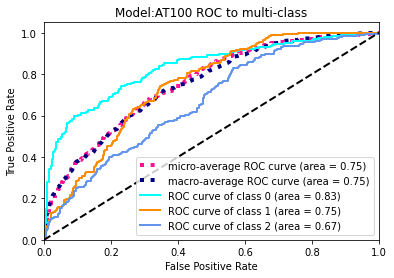

In [ ]:
test_file_name = "Test299.csv"
test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=32,workers=2)
arch="resnet34"
device="cuda"
fix_random_seed(4)
for i in []:#"Model:DPAATab","Model:DPAATa"f"Model:Standard",f"Model:RobustATEps={eps}",f"Model:RobustSATEps={eps}",f"Model:PAAT3",f"Model:PAAT3_robust",f"Model:AMATEps={eps}"
  resume_type=i
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  model.eval()
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    inputs = pgd_attack(model = model, images = inputs, labels = labels, eps=0.3, alpha=0.15, iters=7, device=device)
    outputs = model(inputs)
    score_tmp = outputs

    score_list.extend(score_tmp.detach().cpu().numpy())
    label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)

  print("score_array:", score_array.shape)  # (batchsize, classnum)
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

  # 调用sklearn库，计算每个类别对应的fpr和tpr
  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  # micro
  fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
  roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

  # macro
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
  # Finally average it and compute AUC
  mean_tpr /= 3
  fpr_dict["macro"] = all_fpr
  tpr_dict["macro"] = mean_tpr
  roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

  # 绘制所有类别平均的roc曲线
  plt.figure()
  lw = 2
  plt.plot(fpr_dict["micro"], tpr_dict["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr_dict["macro"], tpr_dict["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["macro"]),
            color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(3), colors):
      plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                      ''.format(i, roc_auc_dict[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{resume_type} ROC to multi-class')
  plt.legend(loc="lower right")
  plt.savefig('set113_roc.jpg')
  plt.show()

score_array: (11, 3)
label_onehot: (11, 3)
(3,) (3,) 1.0
(7,) (7,) 0.8333333333333333
(11,) (11,) 0.7884920634920635
Average precision score, micro-averaged over all classes: 0.75


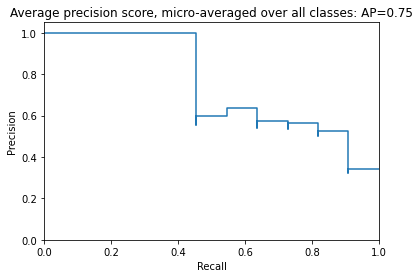

In [ ]:
arch=arch
device=device
fix_random_seed(4)
for i in []:#"Model:DPAATab","Model:DPAATa"f"Model:Standard",f"Model:RobustATEps={eps}",f"Model:RobustSATEps={eps}",f"Model:PAAT3",f"Model:PAAT3_robust",f"Model:AMATEps={eps}"
  resume_type=i
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  model.eval()
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    inputs = pgd_attack(model = model, images = inputs, labels = labels, eps=0.3, alpha=0.15, iters=7, device=device)
    outputs = model(inputs)
    # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
    score_tmp = outputs  # (batchsize, nclass)

  score_list.extend(score_tmp.detach().cpu().numpy())
  label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)
  print("score_array:", score_array.shape)  # (batchsize, classnum) softmax
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum]) onehot

  # 调用sklearn库，计算每个类别对应的precision和recall
  precision_dict = dict()
  recall_dict = dict()
  average_precision_dict = dict()
  for i in range(3):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
    average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
    print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

  # micro
  precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(), score_array.ravel())
  average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_dict["micro"]))

  # 绘制所有类别平均的pr曲线
  plt.figure()#figsize=(10,8)
  plt.step(recall_dict['micro'], precision_dict['micro'], where='post')
  # plt.rcParams.update({'font.size': 12})
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision_dict["micro"]))
  plt.show()




---



# "**Clear GPU Button ⬇⬇⬇⬇**"

In [ ]:
!apt install psmisc
!sudo fuser /dev/nvidia*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
psmisc is already the newest version (23.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/dev/nvidia0:          162m
/dev/nvidiactl:        162m
/dev/nvidia-uvm:       162m


In [ ]:
!kill -9 162

#**——————————↑↑↑↑**



---


# **Ours**

In [ ]:
def PAAT_attack(model=None, x=None, y=None, eps=0,step_size=0,Lstd=0.5,loss_fn= nn.CrossEntropyLoss(),iters=7,device="cuda",expend=1.2):
  y , x = y.to(device) , x.to(device)
  x_adv = pgd_attack(model=model, images=x, labels=y, eps=eps, alpha=step_size, iters=iters, device=device)
  x_adv = Variable(x_adv.cuda(), requires_grad=True)
  y_pred = model(x_adv)
  y_pred1 = model(x)
  p = ch.argmax(y_pred,dim=1)
  loss_adv = loss_fn(y_pred.to(device),y.to(device)).to(device).requires_grad_(True)
  L3  = (loss_adv.item() - Lstd)
  model.zero_grad()
  grad = torch.autograd.grad(loss_adv, x_adv, retain_graph=False, create_graph=False)[0]
  grad_norms = torch.norm(grad.view(x.shape[0], -1), p=2, dim=1) +1e-10
  grad = grad / grad_norms.view(x.shape[0], 1, 1, 1)
  x_adv = x_adv.detach_()
  def udclamp(n, smallest, largest):
    return max(smallest, min(n, largest))
  with ch.no_grad():
    num1=0
    num2=0
    for i in range(len(y)):
      L=(loss_fn(y_pred[i].to("cpu"),y[i].to("cpu")).to("cpu")-loss_fn(y_pred1[i].to("cpu"),y[i].to("cpu")).to("cpu")).item()
      a = (abs(L-L3)/(L3+1e-10))
      output=ch.cdist(x_adv[i].unsqueeze(0).view(-1,224*224*3),x[i].unsqueeze(0).view(-1,224*224*3),p=2).item()
      if L < L3:
        epsilon = abs(output+a*eps)+1e-10
        adv_image = x_adv[i] + (eps/2.)*grad[i]
        diff = adv_image - x[i].data
        diff = diff.renorm(p=2, dim=0, maxnorm=epsilon)
        x_adv[i] = ch.clamp(x[i].data + diff, min=0, max=1)
        num1+=1
      else:
        epsilon = abs(output-a*eps)+1e-10
        epsilon = udclamp(epsilon, 0.01*eps, 0.99*eps)
        diff = x_adv[i].data - x[i].data
        diff = diff.renorm(p=2, dim=0, maxnorm=epsilon)
        x_adv[i] = ch.clamp(x[i].data + diff, min=0, max=1)
        num2+=1
  return x_adv.detach(),num1,num2

In [ ]:
import torch.nn.functional as F
def JSDivLoss(p_output, q_output, get_softmax=True):
    """
    Function that measures JS divergence between target and output logits:
    """
    KLDivLoss = nn.KLDivLoss(reduction='batchmean')
    if get_softmax:
        p_output = F.softmax(p_output,dim=1)
        q_output = F.softmax(q_output,dim=1)
    log_mean_output = ((p_output + q_output )/2).log()
    return (KLDivLoss(log_mean_output, p_output) + KLDivLoss(log_mean_output, q_output))/2

In [ ]:
# 尝试给各部分损失试一下超参数，并可以显示原始图片
num = 0
model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"Model:Standard_best_network.pth")))
model.eval()
loss_fn=nn.CrossEntropyLoss().to("cuda")
for x,y in test_loader:
  x = x.to("cuda")
  y_pred = model(x)
  loss1 = loss_fn(y_pred,y.to("cuda"))
  print(loss1)
  print("Normal Image")
  x_adv = pgd_attack(model=model, images=x, labels=y, eps=0.3, alpha=0.15, iters=7, device="cuda")
  y_pred1 = model(x_adv)
  loss = loss_fn(y_pred1,y.to("cuda"))
  print(loss)
  x_adv,num1,num2=PAAT_attack(model=model, x=x, y=y, eps=0.3 ,step_size=0.15, Lstd=loss1.item(), expend=1.3)
  y_pred2 = model(x_adv)
  loss = JSDivLoss(y_pred2,y_pred)
  print(5*loss)
  for i in range(len(y)):
    print(ch.cdist(x_adv[i].view(-1,224*224*3),x[i].view(-1,224*224*3),p=2))
  inverse_normalize(batch_image=x_adv, batch_label=y)
  num+=1
  if num==1:
    break

In [ ]:
def lmsb_fit( ab, epochs, arch, unreelayer, use_cross_val, cross_file_name, Weight_decay, batch_size, patience,  device, lr, eps, step_size, iterations,
       expend, expid_type,  resume_type, early_epoch, early_repoch,  plot_curve, do_test, do_robustness, seed, loss_fn=nn.CrossEntropyLoss(),test_file_name="Test299.csv",
        train_file_name="Train800.csv::0"):
  fix_random_seed(seed)
  if resume_type:
    model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
    model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
    freeze(model)
    unfreeze(model,unreelayer)
  else:
    model = Model(arch=arch).get_model().to(device)
    freeze(model)
    unfreeze(model,unreelayer)
  if use_cross_val:
    train_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=True, download=None, transform=TRAIN_TRANSFORMS_HAM10000, upsample=True, test=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    val_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=False, download=None, transform=TEST_TRANSFORMS_HAM10000, upsample=True, test=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  else:
    train_loader = CreatDataLoader(root=root,file_name=train_file_name,train=True,transform=TRAIN_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)
    val_loader = CreatDataLoader(root=root,file_name=train_file_name,val=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)

  optimizer = Adam(model.parameters(), lr=lr, weight_decay=Weight_decay)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode='min', patience=patience,threshold=0.0001, threshold_mode='rel', cooldown=0, factor=0.1, min_lr=0, eps=1e-06)
  earlystopping = EarlyStopping(save_path=SAVE_PATH, patience=patience, type=expid_type)
  rearlystopping = R_EarlyStopping(save_path=SAVE_PATH, patience=patience, type=expid_type)
  train_acc, train_loss, val_acc, val_loss, P1, P2 ,R= [], [], [], [], [], [], []
  all_time = 0
  for epoch in range(epochs):
      correct = 0
      total = 0
      running_loss = 0
      num1_ = 0
      num2_ = 0
      model.train()
      starttime = time.time()
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_predstd=model(x)
        loss = loss_fn(y_predstd,y).to(device).requires_grad_(True)
        if ab==0 or ab==1:
          x_adv,num1,num2= PAAT_attack(model=model, x=x, y=y, eps=eps,Lstd=loss.item(),step_size=step_size)
        elif ab==2:
          x_adv = pgd_attack(model = model, images = x, labels = y, eps=eps, alpha=step_size, iters=iterations, device=device)
          num1=num2=0
        y_predlmsb=model(x_adv)
        num1_+=num1
        num2_+=num2
        if ab==1:
          loss_all = 0.4*(loss_fn(y_predlmsb,y).to(device).requires_grad_(True))+0.6*(loss)+10*JSDivLoss(y_predlmsb,y_predstd).to(device).requires_grad_(True)
        elif ab==0 or ab==2:
          loss_all = 0.4*(loss_fn(y_predlmsb,y).to(device).requires_grad_(True))+0.6*(loss)
        model.zero_grad()
        loss_all.backward(retain_graph=True)
        optimizer.step()
        with ch.no_grad():
          y_pred1 = ch.argmax(y_predlmsb, dim=1)
          correct += (y_pred1 == y).sum().item()
          total += y.size(0)
          running_loss += (loss_all.item())
      endtime = time.time()
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = correct / total
      train_acc.append(epoch_acc)
      train_loss.append(epoch_loss)
      all_time+=(endtime - starttime)
      p1 = num1_ /len(train_loader.dataset)
      p2 = num2_ /len(train_loader.dataset)
      P1.append(p1)
      P2.append(p2)

      val_correct = 0
      val_total = 0
      val_running_loss = 0
      robustness = 0
      robustness_acc = 0
      model.eval()
      for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        x_adv = pgd_attack(model = model, images = x, labels = y, eps=eps, alpha=step_size, iters=3, device=device)
        with ch.no_grad():
          y_pred = model(x)
          y_pred1 = model(x_adv)
          loss = loss_fn(y_pred, y)
          y_pred = ch.argmax(y_pred, dim=1)
          y_pred1 = ch.argmax(y_pred1, dim=1)
          robustness += (y_pred1 == y).sum().item()
          val_correct += (y_pred == y).sum().item()
          val_total += y.size(0)
          val_running_loss += loss.item()
      epoch_val_loss = val_running_loss / len(val_loader.dataset)
      epoch_val_acc = val_correct / val_total
      robustness_acc = robustness / val_total
      val_acc.append(epoch_val_acc)
      val_loss.append(epoch_val_loss)
      scheduler.step(epoch_val_loss)
      R.append(robustness_acc)
      if (epoch+1)%early_epoch==0 and early_epoch!=None:
        earlystopping(epoch_val_loss , model)
      if early_repoch!=None:
        rearlystopping(robustness_acc , model)
      lr_last = optimizer.param_groups[0]['lr']
      print(f'[epoch]:{epoch+1}' ,
      f'[lr]:{lr_last}',
      f"[hard_sample_P1]:{round(p1, 3)}",
      f"[soft_sample_P2]:{round(p2, 3)}",
      f"[robustness]:{round(robustness_acc, 3)}",
      f'[train_loss]:{round(epoch_loss, 3)}' ,
      f'[train_accuracy]:{round(epoch_acc, 3)}' ,
      f'[train_time]:{round(endtime-starttime,3)}',
      f'[val_loss]:{round(epoch_val_loss, 3)}',
      f'[val_accuracy]:{round(epoch_val_acc, 3)}')
  print("\nTime Consuming：",all_time)
  if plot_curve:
    plt.figure(figsize=(10,5))
    plt.grid(linestyle="--")
    plt.plot(range(len(train_acc)),train_acc,label="train_acc",color='blue',linewidth=1.5,marker="o")# linewidth=5.0,,linestyle='--'
    plt.plot(range(len(val_acc)),val_acc,label="val_acc",color='green',linewidth=1.5,marker="o")
    plt.ylim((0.1, 1.0))
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Accuracy",fontsize=13, fontweight='bold')
    plt.legend(loc=0, numpoints=1)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.grid(linestyle="--")
    plt.plot(range(len(train_loss)),train_loss,label="train_loss",color='blue',linewidth=1.5,marker="o")
    plt.plot(range(len(val_loss)),val_loss,label="val_loss",color='green',linewidth=1.5,marker="o")
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Loss", fontsize=13, fontweight='bold')
    plt.legend(loc=0, numpoints=1)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.grid(linestyle="--")
    plt.plot(range(len(P1)),P1,label="HardSample",color='blue',linewidth=1.5,marker="o")
    plt.plot(range(len(P2)),P2,label="SoftSample",color='green',linewidth=1.5,marker="o")
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Ratio", fontsize=13, fontweight='bold')
    plt.legend(loc=0, numpoints=1)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.grid(linestyle="--")
    plt.plot(range(len(R)),R,label="val_robust",color='blue',linewidth=1.5,marker="o")
    plt.plot(range(len(val_acc)),val_acc,label="val_acc",color='green',linewidth=1.5,marker="o")
    plt.xlabel("Epochs", fontsize=13, fontweight='bold')
    plt.ylabel("Robustness", fontsize=13, fontweight='bold')
    plt.ylim((0.1, 1.0))
    plt.legend()
    plt.show()
    ch.cuda.empty_cache()
  if do_test:
    test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
  if do_robustness:
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=step_size, iterations=20, device=device)

#**DPAATa**\DPAATab\DPAATb

In [ ]:
# 消融实验a
for eps in [0.3]:#0.8,,2
  lmsb_fit(ab=0, epochs=100, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=32, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:DPAATa", resume_type=f"PGDHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150
[epoch]:1 [lr]:0.0003 [hard_sample_P1]:0.584 [soft_sample_P2]:0.416 [robustness]:0.533 [train_loss]:0.044 [train_accuracy]:0.423 [train_time]:178.132 [val_loss]:0.031 [val_accuracy]:0.58
[epoch]:2 [lr]:0.0003 [hard_sample_P1]:0.588 [soft_sample_P2]:0.412 [robustness]:0.547 [train_loss]:0.026 [train_accuracy]:0.577 [train_time]:173.278 [val_loss]:0.026 [val_accuracy]:0.62
EarlyStopping counter: 1 out of 5
[epoch]:3 [lr]:0.0003 [hard_sample_P1]:0.582 [soft_sample_P2]:0.418 [robustness]:0.593 [train_loss]:0.024 [train_accuracy]:0.602 [train_time]:174.445 [val_loss]:0.028 [val_accuracy]:0.647
[epoch]:4 [lr]:0.0003 [hard_sample_P1]:0.603 [soft_sample_P2]:0.397 [robustness]:0.62 [train_loss]:0.023 [train_accuracy]:0.627 [train_time]:174.577 [val_loss]:0.023 [val_accuracy]:0.727
EarlyStopping counter: 1 out of 5
[epoch]:5 [lr]:0.0003 [hard_sample_P1]:0.599 [soft_sample_P2]:0.401 [robustness]:0.673 [train_

KeyboardInterrupt: ignored

In [ ]:
for eps in [0.3]:
  for expid_type in [f"Model:DPAATa"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
    # robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)

Model:DPAATa
Generalizability： 0.7269076305220884
Robustness (20-PGD)： 0.6144578313253012
Robustness (50-PGD)： 0.6144578313253012
Model:DPAATa
Generalizability： 0.7269076305220884
Robustness (20-PGD)： 0.6144578313253012


KeyboardInterrupt: ignored

In [ ]:
# 消融实验ab
for eps in [0.3]:#0.8,,2
  lmsb_fit(ab=1, epochs=100, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=32, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:DPAATab", resume_type=f"PGDHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)
for eps in [0.3]:
  for expid_type in [f"Model:DPAATab"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150
[epoch]:1 [lr]:0.0003 [hard_sample_P1]:0.576 [soft_sample_P2]:0.424 [robustness]:0.473 [train_loss]:0.053 [train_accuracy]:0.373 [train_time]:176.884 [val_loss]:0.033 [val_accuracy]:0.5
[epoch]:2 [lr]:0.0003 [hard_sample_P1]:0.583 [soft_sample_P2]:0.417 [robustness]:0.6 [train_loss]:0.028 [train_accuracy]:0.563 [train_time]:176.245 [val_loss]:0.026 [val_accuracy]:0.66
[epoch]:3 [lr]:0.0003 [hard_sample_P1]:0.578 [soft_sample_P2]:0.422 [robustness]:0.627 [train_loss]:0.025 [train_accuracy]:0.591 [train_time]:176.155 [val_loss]:0.024 [val_accuracy]:0.673
[epoch]:4 [lr]:0.0003 [hard_sample_P1]:0.605 [soft_sample_P2]:0.395 [robustness]:0.627 [train_loss]:0.024 [train_accuracy]:0.632 [train_time]:176.158 [val_loss]:0.023 [val_accuracy]:0.687
EarlyStopping counter: 1 out of 5
[epoch]:5 [lr]:0.0003 [hard_sample_P1]:0.609 [soft_sample_P2]:0.391 [robustness]:0.653 [train_loss]:0.023 [train_accuracy]:0.635 [

KeyboardInterrupt: ignored

In [ ]:
# 消融实验b
for eps in [0.3]:#0.8,,2
  lmsb_fit(ab=2, epochs=100, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=32, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:DPAATb", resume_type=f"PGDHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)
for eps in [0.3]:
  for expid_type in [f"Model:DPAATb"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150
[epoch]:1 [lr]:0.0003 [hard_sample_P1]:0.0 [soft_sample_P2]:0.0 [robustness]:0.5 [train_loss]:0.045 [train_accuracy]:0.437 [train_time]:165.349 [val_loss]:0.032 [val_accuracy]:0.547
[epoch]:2 [lr]:0.0003 [hard_sample_P1]:0.0 [soft_sample_P2]:0.0 [robustness]:0.573 [train_loss]:0.025 [train_accuracy]:0.59 [train_time]:157.974 [val_loss]:0.026 [val_accuracy]:0.64
EarlyStopping counter: 1 out of 5
[epoch]:3 [lr]:0.0003 [hard_sample_P1]:0.0 [soft_sample_P2]:0.0 [robustness]:0.573 [train_loss]:0.024 [train_accuracy]:0.613 [train_time]:158.074 [val_loss]:0.026 [val_accuracy]:0.647
[epoch]:4 [lr]:0.0003 [hard_sample_P1]:0.0 [soft_sample_P2]:0.0 [robustness]:0.627 [train_loss]:0.023 [train_accuracy]:0.623 [train_time]:157.824 [val_loss]:0.022 [val_accuracy]:0.693
[epoch]:5 [lr]:0.0003 [hard_sample_P1]:0.0 [soft_sample_P2]:0.0 [robustness]:0.667 [train_loss]:0.022 [train_accuracy]:0.641 [train_time]:157.869

KeyboardInterrupt: ignored

In [ ]:
for eps in [0.3]:
  for expid_type in [f"Model:DPAATb_robust"]:#f"Model:DPAATb",
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)

Model:DPAATb_robust
Generalizability： 0.7322623828647925
Robustness (20-PGD)： 0.6157965194109772


# only DPAAT no JS

In [ ]:
for eps in [0.3]:#0.8,,2
  lmsb_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=16, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:onlyPAAT", resume_type=f"PGDHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)
for eps in [0.3]:
  for expid_type in [f"Model:onlyPAAT",f"Model:onlyPAAT_robust"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=1, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=10, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=20, device=device)
for eps in [0.3]:
  for expid_type in [f"Model:onlyPAAT",f"Model:onlyPAAT_robust"]:
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150
[epoch]:1 [lr]:0.0003 [hard_sample_P1]:0.576 [soft_sample_P2]:0.424 [robustness]:0.52 [train_loss]:0.085 [train_accuracy]:0.459 [train_time]:188.794 [val_loss]:0.069 [val_accuracy]:0.62
[epoch]:2 [lr]:0.0003 [hard_sample_P1]:0.58 [soft_sample_P2]:0.42 [robustness]:0.613 [train_loss]:0.055 [train_accuracy]:0.565 [train_time]:182.056 [val_loss]:0.046 [val_accuracy]:0.687
EarlyStopping counter: 1 out of 5
R_EarlyStopping counter: 1 out of 5
[epoch]:3 [lr]:0.0003 [hard_sample_P1]:0.602 [soft_sample_P2]:0.398 [robustness]:0.567 [train_loss]:0.05 [train_accuracy]:0.59 [train_time]:182.049 [val_loss]:0.06 [val_accuracy]:0.647
EarlyStopping counter: 2 out of 5
R_EarlyStopping counter: 2 out of 5
[epoch]:4 [lr]:0.0003 [hard_sample_P1]:0.586 [soft_sample_P2]:0.414 [robustness]:0.567 [train_loss]:0.048 [train_accuracy]:0.612 [train_time]:181.873 [val_loss]:0.058 [val_accuracy]:0.607
EarlyStopping counter: 3 o

## **0.25:0.75:5**----**0.4:0.6:1**----**0.5:0.5:10**




In [ ]:
for eps in [0.3]:#0.8,,2
  # lmsb_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=5,
  #       device="cuda", lr=0.01, eps=eps, step_size=eps/2., iterations=7,
  #      expend=1.5, expid_type=f"PAAT3HeadEps={eps}", resume_type=None, early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
  #      do_robustness=False, seed=4)
  # train_fit(root="/content/data", epochs=10, arch="resnet34", device="cuda", unreelayer=5, patience=10, expid_type=f"PGDHeadEps={eps}",
  #       lr=0.01,  resume_type=None,
  #       use_cross_val=False, cross_file_name=None, train_file_name="Train800.csv::0",test_file_name="Test299.csv", batch_size=64,
  #       Use_pgd=True, Eps=eps, Step_size=eps/2., iterations=7,
  #       plot_curve=False, do_test=True, do_robustness=None,
  #       Weight_decay=5e-4,early_epoch=1,seed=4)
  lmsb_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-5, batch_size=64, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:PAAT3", resume_type=f"PGDHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150
[epoch]:1 [lr]:0.0003 [hard_sample_P1]:0.564 [soft_sample_P2]:0.436 [robustness]:0.56 [train_loss]:0.031 [train_accuracy]:0.318 [train_time]:186.439 [val_loss]:0.019 [val_accuracy]:0.613
[epoch]:2 [lr]:0.0003 [hard_sample_P1]:0.579 [soft_sample_P2]:0.421 [robustness]:0.607 [train_loss]:0.015 [train_accuracy]:0.551 [train_time]:177.284 [val_loss]:0.015 [val_accuracy]:0.673
EarlyStopping counter: 1 out of 5
R_EarlyStopping counter: 1 out of 5
[epoch]:3 [lr]:0.0003 [hard_sample_P1]:0.59 [soft_sample_P2]:0.41 [robustness]:0.567 [train_loss]:0.013 [train_accuracy]:0.605 [train_time]:176.897 [val_loss]:0.018 [val_accuracy]:0.613
[epoch]:4 [lr]:0.0003 [hard_sample_P1]:0.611 [soft_sample_P2]:0.389 [robustness]:0.68 [train_loss]:0.013 [train_accuracy]:0.621 [train_time]:176.943 [val_loss]:0.013 [val_accuracy]:0.74
EarlyStopping counter: 1 out of 5
R_EarlyStopping counter: 1 out of 5
[epoch]:5 [lr]:0.0003 [h

KeyboardInterrupt: ignored

In [ ]:
for eps in [0.3]:
  for expid_type in [f"Model:PAAT3",f"Model:PAAT3_robust"]:
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=1, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=10, device=device)
    robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=20, device=device)

Model:PAAT3
Generalizability： 0.7215528781793842
Robustness (20-PGD)： 0.6532797858099063
Robustness (50-PGD)： 0.6532797858099063
Robustness (100-PGD)： 0.6532797858099063
Robustness (1-IFGSM)： 0.713520749665328
Robustness (10-IFGSM)： 0.5823293172690763
Robustness (20-IFGSM)： 0.5060240963855421
Model:PAAT3_robust
Generalizability： 0.7309236947791165
Robustness (20-PGD)： 0.6506024096385542
Robustness (50-PGD)： 0.6506024096385542
Robustness (100-PGD)： 0.6506024096385542
Robustness (1-IFGSM)： 0.714859437751004
Robustness (10-IFGSM)： 0.5809906291834003
Robustness (20-IFGSM)： 0.5073627844712182


In [ ]:
for eps in [1.0]:#0.8,,2
  lmsb_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=5,
        device="cuda", lr=0.01, eps=eps, step_size=eps/2., iterations=3,
       expend=1.5, expid_type=f"PAATHeadEps={eps}", resume_type=None, early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)
  lmsb_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=16, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=3,
       expend=1.5, expid_type=f"Model:PAATeps={eps}", resume_type=f"PAATHeadEps={eps}", early_epoch=1, early_repoch=1,plot_curve=None, do_test=None,
       do_robustness=False, seed=4)

## **expend=1.5**

In [ ]:
for eps in [0.2,0.3]:#0.8,,2
  lmsb_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=10,
        device="cuda", lr=0.01, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"ABTS1_Head_e=1.5_Eps={eps}", resume_type=None, early_epoch=1,early_repoch=None, plot_curve=False, do_test=True,
       do_robustness=False, seed=4)
  lmsb_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=16, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.5, expid_type=f"Model:RobustABTS1e=1.5Eps={eps}", resume_type=f"ABTS1_Head_e=1.5_Eps={eps}", early_epoch=1, early_repoch=1,plot_curve=True, do_test=True,
       do_robustness=False, seed=4)
for eps in [0.2,0.3]:#0.8,,2
  normal_images_accuracy(save_type=f"Model:RobustABTS1e=1.5Eps={eps}",testloader=test_loader,arch="resnet34",device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device="cuda")

  normal_images_accuracy(save_type=f"Model:RobustABTS1e=1.5Eps={eps}_robust",testloader=test_loader,arch="resnet34",device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.5Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device="cuda")

# **expend=1.25**

In [ ]:
for eps in [0.2,0.3]:
  lmsb_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=10,
        device="cuda", lr=0.01, eps=eps, step_size=eps/2., iterations=7,
       expend=1.25, expid_type=f"ABTS1_Head_e=1.25_Eps={eps}", resume_type=None, early_epoch=1,early_repoch=None, plot_curve=False, do_test=True,
       do_robustness=False, seed=4)
  lmsb_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=16, patience=5,
        device="cuda", lr=0.0003, eps=eps, step_size=eps/2., iterations=7,
       expend=1.25, expid_type=f"Model:RobustABTS1e=1.25Eps={eps}", resume_type=f"ABTS1_Head_e=1.25_Eps={eps}", early_epoch=1, early_repoch=1,plot_curve=True, do_test=True,
       do_robustness=False, seed=4)
for eps in [0.2,0.3]:#0.8,,2
  normal_images_accuracy(save_type=f"Model:RobustABTS1e=1.25Eps={eps}",testloader=test_loader,arch="resnet34",device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device="cuda")

  normal_images_accuracy(save_type=f"Model:RobustABTS1e=1.25Eps={eps}_robust",testloader=test_loader,arch="resnet34",device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device="cuda")
  robustness_eval(save_type=f"Model:RobustABTS1e=1.25Eps={eps}_robust", arch="resnet34",testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device="cuda")

Created dataset of length: 747
score_array: (747, 3)
label_onehot: (747, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


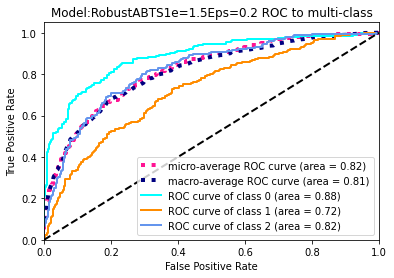

score_array: (747, 3)
label_onehot: (747, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


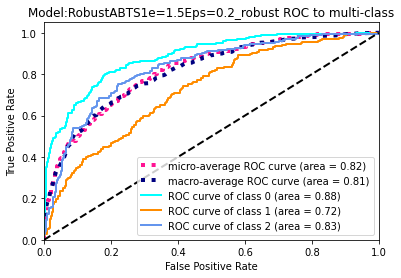

In [ ]:
test_file_name = "Test299.csv"
test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=32,workers=2)
arch="resnet34"
device="cuda"
for resume_type in [f"Model:RobustABTS1e=1.5Eps=0.2",f"Model:RobustABTS1e=1.5Eps=0.2_robust"]:#,1.0,1.2
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()

    outputs = model(inputs)
    score_tmp = outputs

    score_list.extend(score_tmp.detach().cpu().numpy())
    label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)

  print("score_array:", score_array.shape)  # (batchsize, classnum)
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

  # 调用sklearn库，计算每个类别对应的fpr和tpr
  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  # micro
  fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
  roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

  # macro
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
  # Finally average it and compute AUC
  mean_tpr /= 3
  fpr_dict["macro"] = all_fpr
  tpr_dict["macro"] = mean_tpr
  roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

  # 绘制所有类别平均的roc曲线
  plt.figure()
  lw = 2
  plt.plot(fpr_dict["micro"], tpr_dict["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr_dict["macro"], tpr_dict["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["macro"]),
            color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(3), colors):
      plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                      ''.format(i, roc_auc_dict[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{resume_type} ROC to multi-class')
  plt.legend(loc="lower right")
  plt.savefig('set113_roc.jpg')
  plt.show()

score_array: (11, 3)
label_onehot: (11, 3)
(6,) (6,) 0.8041666666666667
(11,) (11,) 0.5821428571428571
(10,) (10,) 0.7777777777777777
Average precision score, micro-averaged over all classes: 0.67


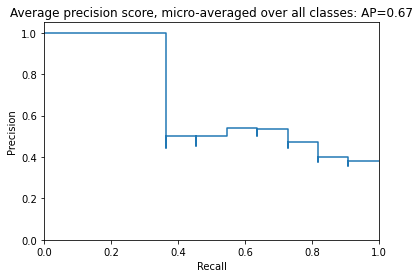

score_array: (11, 3)
label_onehot: (11, 3)
(11,) (11,) 0.2
(10,) (10,) 0.49999999999999994
(11,) (11,) 0.9055555555555554
Average precision score, micro-averaged over all classes: 0.63


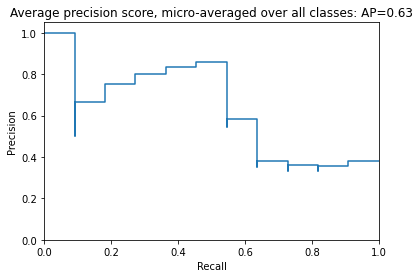

In [ ]:
arch=arch
device=device
for resume_type in [f"Model:RobustABTS1e=1.5Eps=0.2",f"Model:RobustABTS1e=1.5Eps=0.2_robust"]:#,1.0,1.2
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()

    outputs = model(inputs)
    # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
    score_tmp = outputs  # (batchsize, nclass)

  score_list.extend(score_tmp.detach().cpu().numpy())
  label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)
  print("score_array:", score_array.shape)  # (batchsize, classnum) softmax
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum]) onehot

  # 调用sklearn库，计算每个类别对应的precision和recall
  precision_dict = dict()
  recall_dict = dict()
  average_precision_dict = dict()
  for i in range(3):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
    average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
    print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

  # micro
  precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(), score_array.ravel())
  average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_dict["micro"]))

  # 绘制所有类别平均的pr曲线
  plt.figure()#figsize=(10,8)
  plt.step(recall_dict['micro'], precision_dict['micro'], where='post')
  # plt.rcParams.update({'font.size': 12})
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision_dict["micro"]))
  plt.show()

# **AMAT**

Created dataset of length: 2400
0.16354575753211975 1.1600910425186157


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


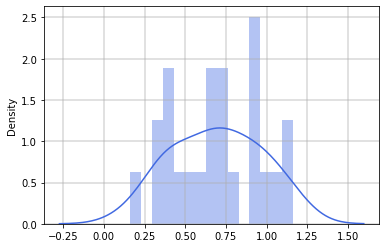

0.6917410753667355
0.07207712013581408
0.26847182372795486
0.8358953156383636


In [ ]:
model = Model(arch="resnet34",pretrained=False,prestart=False).get_model().to("cuda")
model.load_state_dict(ch.load('/content/drive/MyDrive/HAM10000/ResNet34/PGD-CATS/Model:Standard_best_network.pth'))
train_file_name = "Train800.csv::0"
train_loader = CreatDataLoader(root=root,file_name=train_file_name,train=True,transform=TRAIN_TRANSFORMS_HAM10000,batch_size=64,workers=2)
model.eval()

loss_value = []
loss_fn = nn.CrossEntropyLoss()
for x, y in test_loader:
  if torch.cuda.is_available():
    x, y = x.to('cuda'), y.to('cuda')
  y_pred = model(x)
  loss = loss_fn(y_pred, y)
  loss_value.append(loss.item())
print(min(loss_value),max(loss_value))
plt.grid(linestyle="-", alpha=0.5,linewidth=1.5)
sns.distplot(loss_value, 15 ,hist=True,kde=True,color='royalblue')
plt.show()
print(np.mean(loss_value))
print(np.var(loss_value))
print(np.std(loss_value))
L = np.mean(loss_value)+2*np.var(loss_value)
print(L)

In [ ]:
def AMAT_attack(model=None, x=None, y=None, eps=0,step_size=0,L=0.5,loss_fn= nn.CrossEntropyLoss(),iters=5,device="cuda",expend=0.1):
  y , x = y.to(device) , x.to(device)
  x_adv = pgd_attack(model=model, images=x, labels=y, eps=eps, alpha=step_size, iters=iters, device=device)
  x_adv = Variable(x_adv.cuda(), requires_grad=True)
  y_pred = model(x_adv)
  y_pred1 = model(x)
  loss_adv = loss_fn(y_pred.to(device),y.to(device)).to(device).requires_grad_(True)
  model.zero_grad()
  grad = torch.autograd.grad(loss_adv, x_adv, retain_graph=False, create_graph=False)[0]
  grad_norms = torch.norm(grad.view(x.shape[0], -1), p=2, dim=1) +1e-10
  grad = grad / grad_norms.view(x.shape[0], 1, 1, 1)
  x_adv = x_adv.detach_()
  with ch.no_grad():
    num1=0
    num2=0
    for i in range(len(y)):
      L1 = loss_fn(y_pred[i].to("cpu"),y[i].to("cpu")).to("cpu")
      output=ch.cdist(x_adv[i].unsqueeze(0).view(-1,224*224*3),x[i].unsqueeze(0).view(-1,224*224*3),p=2).item()
      #print(output)
      if L1 < L:
        epsilon = abs(eps+expend)
        adv_image = x_adv[i] + (eps/2.)*grad[i]
        diff = adv_image - x[i].data
        diff = diff.renorm(p=2, dim=0, maxnorm=epsilon)
        x_adv[i] = ch.clamp(x[i].data + diff, min=0, max=1)
        num1+=1
        #print('hou1',ch.cdist(x_adv[i].unsqueeze(0).view(-1,224*224*3),x[i].unsqueeze(0).view(-1,224*224*3),p=2).item())
      else:
        epsilon = abs((output+L)/2.)
        # adv_image = x_adv[i] - (eps/2.)*grad[i]
        diff = x_adv[i].data - x[i].data
        diff = diff.renorm(p=2, dim=0, maxnorm=epsilon)
        x_adv[i] = ch.clamp(x[i].data + diff, min=0, max=1)
        num2+=1
        #print("hou2",ch.cdist(x_adv[i].unsqueeze(0).view(-1,224*224*3),x[i].unsqueeze(0).view(-1,224*224*3),p=2).item())
  return x_adv.detach(),num1,num2

In [ ]:
def amat_fit( epochs, arch, unreelayer, use_cross_val, cross_file_name, Weight_decay, batch_size, patience,  device, lr, eps, step_size, iterations,
       expend, L, expid_type,  resume_type, early_epoch,  plot_curve, do_test, do_robustness, seed, loss_fn=nn.CrossEntropyLoss(),test_file_name="Test299.csv",
        train_file_name="Train800.csv::0"):
  fix_random_seed(seed)
  if resume_type:
    model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
    model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
    freeze(model)
    unfreeze(model,unreelayer)
  else:
    model = Model(arch=arch).get_model().to(device)
    freeze(model)
    unfreeze(model,unreelayer)
  if use_cross_val:
    train_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=True, download=None, transform=TRAIN_TRANSFORMS_HAM10000, upsample=True, test=False)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    val_set = HAM10000_dataset_3cls_balanced(root=root, file_name=cross_file_name, train=False, download=None, transform=TEST_TRANSFORMS_HAM10000, upsample=True, test=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  else:
    train_loader = CreatDataLoader(root=root,file_name=train_file_name,train=True,transform=TRAIN_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)
    val_loader = CreatDataLoader(root=root,file_name=train_file_name,val=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)

  optimizer = Adam(model.parameters(), lr=lr, weight_decay=Weight_decay)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode='min', patience=patience,threshold=0.0001, threshold_mode='rel', cooldown=0, factor=0.1, min_lr=0, eps=1e-06)
  earlystopping = EarlyStopping(save_path=SAVE_PATH, patience=patience, type=expid_type)
  train_acc, train_loss, val_acc, val_loss = [], [], [], []
  all_time = 0
  for epoch in range(epochs):
      correct = 0
      total = 0
      running_loss = 0
      model.train()
      starttime = time.time()
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_predstd=model(x)
        x_adv,num1,num2= AMAT_attack(model=model, x=x, y=y, eps=eps ,step_size=step_size, expend=expend, L=L,iters=iterations)
        y_predl=model(x_adv)
        loss_all = (loss_fn(y_predl,y).to(device).requires_grad_(True)+loss_fn(y_predstd,y).to(device).requires_grad_(True))/2.
        model.zero_grad()
        loss_all.backward(retain_graph=True)
        optimizer.step()
        with ch.no_grad():
          y_pred1 = ch.argmax(y_predl, dim=1)
          correct += (y_pred1 == y).sum().item()
          total += y.size(0)
          running_loss += (loss_all.item())
      endtime = time.time()
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = correct / total
      train_acc.append(epoch_acc)
      train_loss.append(epoch_loss)
      all_time+=(endtime - starttime)

      val_correct = 0
      val_total = 0
      val_running_loss = 0
      model.eval()
      for x, y in val_loader:
        with ch.no_grad():
          x, y = x.to(device), y.to(device)
          y_pred = model(x)
          loss = loss_fn(y_pred, y)
          y_pred = ch.argmax(y_pred, dim=1)
          val_correct += (y_pred == y).sum().item()
          val_total += y.size(0)
          val_running_loss += loss.item()
      epoch_val_loss = val_running_loss / len(val_loader.dataset)
      epoch_val_acc = val_correct / val_total
      val_acc.append(epoch_val_acc)
      val_loss.append(epoch_val_loss)
      scheduler.step(epoch_val_loss)
      if (epoch+1)%early_epoch==0 and early_epoch!=None:
        earlystopping(epoch_val_loss , model)
      lr_last = optimizer.param_groups[0]['lr']
      print(f'[epoch]:{epoch+1}' ,
      f'[lr]:{lr_last}',
      f'[train_loss]:{round(epoch_loss, 3)}' ,
      f'[train_accuracy]:{round(epoch_acc, 3)}' ,
      f'[train_time]:{round(endtime-starttime,3)}',
      f'[val_loss]:{round(epoch_val_loss, 3)}',
      f'[val_accuracy]:{round(epoch_val_acc, 3)}')
  print("\nTime Consuming：",all_time)
  if plot_curve:
    plt.figure(figsize=(8,5))
    plt.plot(range(len(train_acc)),train_acc,label="train_acc",color='blue')# linewidth=5.0,,linestyle='--'
    plt.plot(range(len(val_acc)),val_acc,label="val_acc",color='green')
    plt.ylim((0.1, 1.0))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(range(len(train_loss)),train_loss,label="train_loss",color='blue',linestyle='--')
    plt.plot(range(len(val_loss)),val_loss,label="val_loss",color='green',linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    ch.cuda.empty_cache()
  if do_test:
    test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=batch_size,workers=2)
    normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
  if do_robustness:
    robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=step_size, iterations=20, device=device)

In [ ]:
for eps in [0.3]:
  # amat_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=5,  device="cuda", lr=1e-2, eps=eps, step_size=eps/2., iterations=7,
  #      expend=0.1, L=0.83, expid_type=f"AMATHeadEps={eps}",  resume_type=None, early_epoch=1,  plot_curve=True, do_test=True, do_robustness=None, seed=4)
  amat_fit( epochs=100, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=32, patience=5,  device="cuda", lr=3e-4, eps=eps, step_size=eps/2., iterations=7,
       expend=0.1, L=L, expid_type=f"Model:AMAT100",  resume_type=f"PGDHeadEps={eps}", early_epoch=1,  plot_curve=True, do_test=True, do_robustness=None, seed=4)

In [ ]:
for eps in [0.3]:
  # amat_fit( epochs=10, arch="resnet34", unreelayer=5, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=64, patience=5,  device="cuda", lr=1e-2, eps=eps, step_size=eps/2., iterations=7,
  #      expend=0.1, L=0.83, expid_type=f"AMATHeadEps={eps}",  resume_type=None, early_epoch=1,  plot_curve=True, do_test=True, do_robustness=None, seed=4)
  amat_fit( epochs=50, arch="resnet34", unreelayer=1, use_cross_val=None, cross_file_name=None, Weight_decay=5e-4, batch_size=32, patience=5,  device="cuda", lr=3e-4, eps=eps, step_size=eps/2., iterations=7,
       expend=0.1, L=0.83, expid_type=f"Model:AMATEps={eps}",  resume_type=f"PGDHeadEps={eps}", early_epoch=1,  plot_curve=True, do_test=True, do_robustness=None, seed=4)

Unfrozen the entire model
Created dataset of length: 2400
Created dataset of length: 150


In [ ]:
expid_type=f"Model:AMATEps=0.3"
normal_images_accuracy(save_type=expid_type,testloader=test_loader,arch=arch,device=device)
for eps in [0.3]:
  print(f"EPS={eps}")
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=20, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=50, device=device)
  robustness_eval(save_type=expid_type, arch=arch,testloader=test_loader,eps=eps, step_size=eps/2., iterations=100, device=device)
  robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=1, device=device)
  robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=10, device=device)
  robustness_eval(pgd=None,ifgm=True,save_type=expid_type, arch=arch,testloader=test_loader,eps=0.003, step_size=0.0002, iterations=20, device=device)

Model:AMATEps=0.3
Generalizability： 0.7188755020080321
EPS=0.3
Robustness (20-PGD)： 0.6037483266398929
Robustness (50-PGD)： 0.6050870147255689
Robustness (100-PGD)： 0.6037483266398929
Robustness (1-IFGSM)： 0.6987951807228916
Robustness (10-IFGSM)： 0.5207496653279786
Robustness (20-IFGSM)： 0.428380187416332


In [ ]:
root = "/content/data"
train_file_name="Train.csv::0"
test_file_name="Test.csv"
train_loader = CreatDataLoader(root=root,file_name=train_file_name,train=True,transform=TRAIN_TRANSFORMS_HAM10000,batch_size=16,workers=2,shuffle=True)
test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=16,workers=2,shuffle=True)
val_loader = CreatDataLoader(root=root,file_name=train_file_name,val=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=16,workers=2,shuffle=True)



---



Created dataset of length: 747
score_array: (747, 3)
label_onehot: (747, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


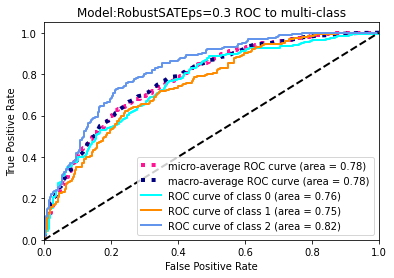

In [ ]:
test_file_name = "Test299.csv"
test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=32,workers=2)
arch="resnet34"
device="cuda"
for resume_type in [f"Model:RobustSATEps=0.3"]:#,1.0,1.2
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()

    outputs = model(inputs)
    score_tmp = outputs

    score_list.extend(score_tmp.detach().cpu().numpy())
    label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)

  print("score_array:", score_array.shape)  # (batchsize, classnum)
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum])

  # 调用sklearn库，计算每个类别对应的fpr和tpr
  fpr_dict = dict()
  tpr_dict = dict()
  roc_auc_dict = dict()
  for i in range(3):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(label_onehot[:, i], score_array[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
  # micro
  fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(label_onehot.ravel(), score_array.ravel())
  roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

  # macro
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(3)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
  # Finally average it and compute AUC
  mean_tpr /= 3
  fpr_dict["macro"] = all_fpr
  tpr_dict["macro"] = mean_tpr
  roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

  # 绘制所有类别平均的roc曲线
  plt.figure()
  lw = 2
  plt.plot(fpr_dict["micro"], tpr_dict["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr_dict["macro"], tpr_dict["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc_dict["macro"]),
            color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(3), colors):
      plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                      ''.format(i, roc_auc_dict[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{resume_type} ROC to multi-class')
  plt.legend(loc="lower right")
  plt.savefig('set113_roc.jpg')
  plt.show()

score_array: (11, 3)
label_onehot: (11, 3)
(10,) (10,) 0.8711111111111112
(9,) (9,) 0.7226190476190476
(4,) (4,) 0.3333333333333333
Average precision score, micro-averaged over all classes: 0.63


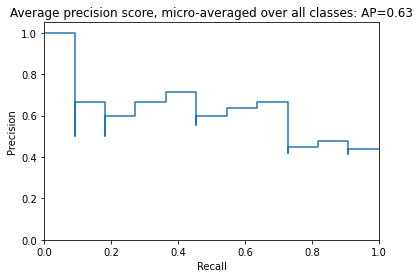

In [ ]:
arch=arch
device=device
for resume_type in [f"Model:RobustSATEps=0.3"]:#,1.0,1.2
  model = Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
  model.load_state_dict(ch.load(os.path.join(SAVE_PATH,f"{resume_type}_best_network.pth")))
  score_list = []     # 存储预测得分
  label_list = []     # 存储真实标签
  for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.cuda()
    labels = labels.cuda()

    outputs = model(inputs)
    # prob_tmp = torch.nn.Softmax(dim=1)(outputs) # (batchsize, nclass)
    score_tmp = outputs  # (batchsize, nclass)

  score_list.extend(score_tmp.detach().cpu().numpy())
  label_list.extend(labels.cpu().numpy())

  score_array = np.array(score_list)
  # 将label转换成onehot形式
  label_tensor = torch.tensor(label_list)
  label_tensor = label_tensor.reshape((label_tensor.shape[0], 1))
  label_onehot = torch.zeros(label_tensor.shape[0], 3)
  label_onehot.scatter_(dim=1, index=label_tensor, value=1)
  label_onehot = np.array(label_onehot)
  print("score_array:", score_array.shape)  # (batchsize, classnum) softmax
  print("label_onehot:", label_onehot.shape)  # torch.Size([batchsize, classnum]) onehot

  # 调用sklearn库，计算每个类别对应的precision和recall
  precision_dict = dict()
  recall_dict = dict()
  average_precision_dict = dict()
  for i in range(3):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(label_onehot[:, i], score_array[:, i])
    average_precision_dict[i] = average_precision_score(label_onehot[:, i], score_array[:, i])
    print(precision_dict[i].shape, recall_dict[i].shape, average_precision_dict[i])

  # micro
  precision_dict["micro"], recall_dict["micro"], _ = precision_recall_curve(label_onehot.ravel(), score_array.ravel())
  average_precision_dict["micro"] = average_precision_score(label_onehot, score_array, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_dict["micro"]))

  # 绘制所有类别平均的pr曲线
  plt.figure()#figsize=(10,8)
  plt.step(recall_dict['micro'], precision_dict['micro'], where='post')
  # plt.rcParams.update({'font.size': 12})
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision_dict["micro"]))
  plt.show()

In [ ]:
import cv2
def draw_features(width,height,x):
  tic=time.time()
  fig = plt.figure(figsize=(16, 16))
  fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05, hspace=0.05)
  for i in range(width*height):
    plt.subplot(height,width, i + 1)
    plt.axis('off')
    # plt.tight_layout()
    img = x[0, i, :, :]
    pmin = np.min(img)
    pmax = np.max(img)
    img = (img - pmin) / (pmax - pmin + 0.000001)
    plt.imshow(img, cmap='gray')
    # print("{}/{}".format(i,width*height))
  plt.show()
  fig.clf()
  plt.close()
  print("time:{}".format(time.time()-tic))
class ft_net(nn.Module):
  def __init__(self,type):
    super(ft_net, self).__init__()
    model_ft =  Model(arch=arch,pretrained=False,prestart=False).get_model().to(device)
    model_ft.load_state_dict(ch.load(os.path.join(SAVE_PATH,type)))
    self.model = model_ft
  def forward(self, x):
    if True: # draw features or not
      x = self.model.conv1(x)

      x = self.model.bn1(x)
      x = self.model.relu(x)
      x = self.model.maxpool(x)
      x = self.model.layer1(x)
      x = self.model.layer2(x)
      x = self.model.layer3(x)
      x = self.model.layer4(x)
      print("Feature map of layer4")
      draw_features(8, 8, x.cpu().numpy())
def features_map(type="Standard_FINAL_lr=3e-4"):
  savepath=f"{type}_best_network.pth"
  device="cuda"
  arch="resnet34"
  model=ft_net(savepath).to("cuda")
  model.eval()
  test_file_name = "3cls_balanced_test_without_val.csv"
  num=0
  test_loader = CreatDataLoader(root=root,file_name=test_file_name,test=True,transform=TEST_TRANSFORMS_HAM10000,batch_size=8,workers=2)
  for x,y in test_loader:
    x = x.to("cuda")
    num+=1
    out=model(x)
    if num==1:
      break